In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.9.0+cu126
12.6


In [5]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.7 MB/s eta 0:00:00


In [6]:
# Imports and initial settings

import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv, Linear, GCNConv, GATv2Conv
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [5]:
# Loading + Smart Filter (ABC Analysis)

import pandas as pd

# --- Load data and time filter (Colab local storage) ---
data_path = '/content/anonymized_prescription.csv'
df = pd.read_csv(data_path, encoding='latin1')

# Ensure year and month are numeric before creating date_key
df['Prescription_year'] = pd.to_numeric(df['Prescription_year'], errors='coerce').fillna(0).astype(int)
df['Prescription_month'] = pd.to_numeric(df['Prescription_month'], errors='coerce').fillna(0).astype(int)

df['date_key'] = df['Prescription_year'] * 100 + df['Prescription_month']
df_clean = df[(df['date_key'] >= 9701) & (df['date_key'] <= 9812)].copy()

print(f"Total number of original records: {len(df_clean)}")
print(f"Total number of unique drugs: {df_clean['Drug_code'].nunique()}")

# --- Smart filter strategy ---

# Criterion 1: Sales volume
drug_counts = df_clean.groupby('Drug_code').size().reset_index(name='frequency')

# Criterion 2: Consistency
# Must be present in multiple months to be predictable
drug_presence = df_clean.groupby('Drug_code')['date_key'].nunique().reset_index(name='months_present')

# Combine criteria
drug_stats = pd.merge(drug_counts, drug_presence, on='Drug_code')

# --- Filter condition ---
min_months = 12
quantile_threshold = 0.70  # top 30%

threshold_freq = drug_stats['frequency'].quantile(quantile_threshold)

selected_drugs_df = drug_stats[
    (drug_stats['frequency'] >= threshold_freq) &
    (drug_stats['months_present'] >= min_months)
]

target_drug_codes = selected_drugs_df['Drug_code'].tolist()

print(f"Sales threshold: {threshold_freq}")
print(f"Number of drugs selected for modeling: {len(target_drug_codes)}")

# Apply filter to original dataframe
df_clean = df_clean[df_clean['Drug_code'].isin(target_drug_codes)].copy()

print(f"Number of records remaining for graph: {len(df_clean)}")

/tmp/ipython-input-1919823548.py:7: DtypeWarning: Columns (0,1,2,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, encoding='latin1')


Total number of original records: 2616780
Total number of unique drugs: 2924
Sales threshold: 187.0999999999999
Number of drugs selected for modeling: 863
Number of records remaining for graph: 2540563


In [7]:
!pip install jdatetime


In [8]:
# Converting solar date to Gregorian (Gregorian Conversion)


import pandas as pd
try:
    import jdatetime
    HAS_JDATETIME = True
except ImportError:
    HAS_JDATETIME = False
    print("⚠️ jdatetime library not found. Approximate conversion used.")

def convert_to_gregorian(row):
    # Year normalization (97 -> 1397)
    j_year = 1300 + row['Prescription_year']
    j_month = row['Prescription_month']

    if HAS_JDATETIME:
        # Exact conversion (assuming the first day of the month)
        try:
            g_date = jdatetime.date(j_year, j_month, 1).togregorian()
            return pd.Timestamp(g_date)
        except:
            return pd.NaT
    else:
        # Approximate conversion (start of solar year ≈ March 21)
        # This section is only for when jdatetime is not installed
        g_year = j_year + 621
        # Approximate month conversion (first 3 months of the Gregorian year are from the previous solar year, but we'll simplify it here)
        # The exact formula is complicated without the library, so we assume the user has jdatetime installed.
        return pd.Timestamp(f"{g_year}-{j_month}-01") # Placeholder

# Apply conversion
print("⏳ Converting dates to Gregorian...")
df_clean['Gregorian_Date'] = df_clean.apply(convert_to_gregorian, axis=1)

# Create string columns to display in the chart
df_clean['Year_Month_Str'] = df_clean['Gregorian_Date'].dt.strftime('%Y-%m')
df_clean['G_Year'] = df_clean['Gregorian_Date'].dt.year
df_clean['G_Month'] = df_clean['Gregorian_Date'].dt.month_name().str[:3] # Jan, Feb, ...

print("✅ Date conversion completed. Example:")
print(df_clean[['Prescription_year', 'Prescription_month', 'Year_Month_Str']].head())

⏳ Converting dates to Gregorian...
✅ Date conversion completed. Example:
   Prescription_year  Prescription_month Year_Month_Str
0                 97                   1        2018-03
1                 97                   1        2018-03
2                 97                   1        2018-03
3                 97                   1        2018-03
4                 97                   1        2018-03


In [10]:
from scipy.stats import skew, kurtosis

# Assumes df_clean is already loaded
# If the price or quantity column has a different name, modify here
col_vol = 'Drug_number'
col_price = 'Drug_price'

# Ensure these columns are numeric
df_clean[col_vol] = pd.to_numeric(df_clean[col_vol], errors='coerce')
df_clean[col_price] = pd.to_numeric(df_clean[col_price], errors='coerce')

# 1. Calculating the main descriptive statistics (Numerical Stats)

desc_stats = df_clean[[col_vol, col_price]].describe().T
desc_stats['skewness'] = df_clean[[col_vol, col_price]].apply(lambda x: skew(x.dropna()))
desc_stats['kurtosis'] = df_clean[[col_vol, col_price]].apply(lambda x: kurtosis(x.dropna()))

# Select and rename columns to display in the report
final_stats_table = desc_stats[['count', 'mean', 'std', 'min', '50%', 'max', 'skewness', 'kurtosis']]
final_stats_table.columns = ['Count', 'Mean', 'Std Dev', 'Min', 'Median', 'Max', 'Skewness', 'Kurtosis']

# Number formatting (for better display)
pd.options.display.float_format = '{:,.2f}'.format

print("--- Table 1: Statistical summary of quantitative variables ---")
print(final_stats_table)

# 2. Calculating Cardinality Stats

# Convert date to calculate interval
if 'Gregorian_Date' in df_clean.columns:
    date_col = 'Gregorian_Date'
else:
    df_clean['temp_date'] = pd.to_datetime(df_clean['Prescription_year'].astype(str) + '-' +
                                           df_clean['Prescription_month'].astype(str) + '-01')
    date_col = 'temp_date'

general_info = {
    'Total Records (Transactions)': len(df_clean),
    'Total Prescriptions': df_clean['Prescription_id'].nunique() if 'Prescription_id' in df_clean.columns else 'N/A',
    'Unique Drugs': df_clean['Drug_code'].nunique(),
    'Unique Doctors': df_clean['Doctor_id'].nunique(),
    'Unique Patients': df_clean['Patient_id'].nunique(),
    'Time Span (Months)': df_clean[date_col].nunique(),
    'Start Date': df_clean[date_col].min().strftime('%Y-%m'),
    'End Date': df_clean[date_col].max().strftime('%Y-%m')
}

general_df = pd.DataFrame(list(general_info.items()), columns=['Metric', 'Value'])

print("\n--- Table 2: General characteristics of the data set ---")
print(general_df)


#3. Save output for reporting

# Save to CSV for copying to report
final_stats_table.to_csv('Table_4_1_Descriptive_Stats.csv')
general_df.to_csv('Table_4_2_General_Info.csv', index=False)

--- Table 1: Statistical summary of quantitative variables ---
                   Count       Mean    Std Dev  Min    Median           Max  \
Drug_number 2,540,563.00      32.09      38.55 0.00     20.00        910.00   
Drug_price  2,540,563.00 118,580.03 574,482.45 0.00 41,200.00 42,000,000.00   

             Skewness  Kurtosis  
Drug_number      2.16      9.80  
Drug_price      32.79  1,657.20  

--- Table 2: General characteristics of the data set ---
                         Metric    Value
0  Total Records (Transactions)  2540563
1           Total Prescriptions   957587
2                  Unique Drugs      863
3                Unique Doctors     5296
4               Unique Patients   206504
5            Time Span (Months)       24
6                    Start Date  2018-03
7                      End Date  2020-02


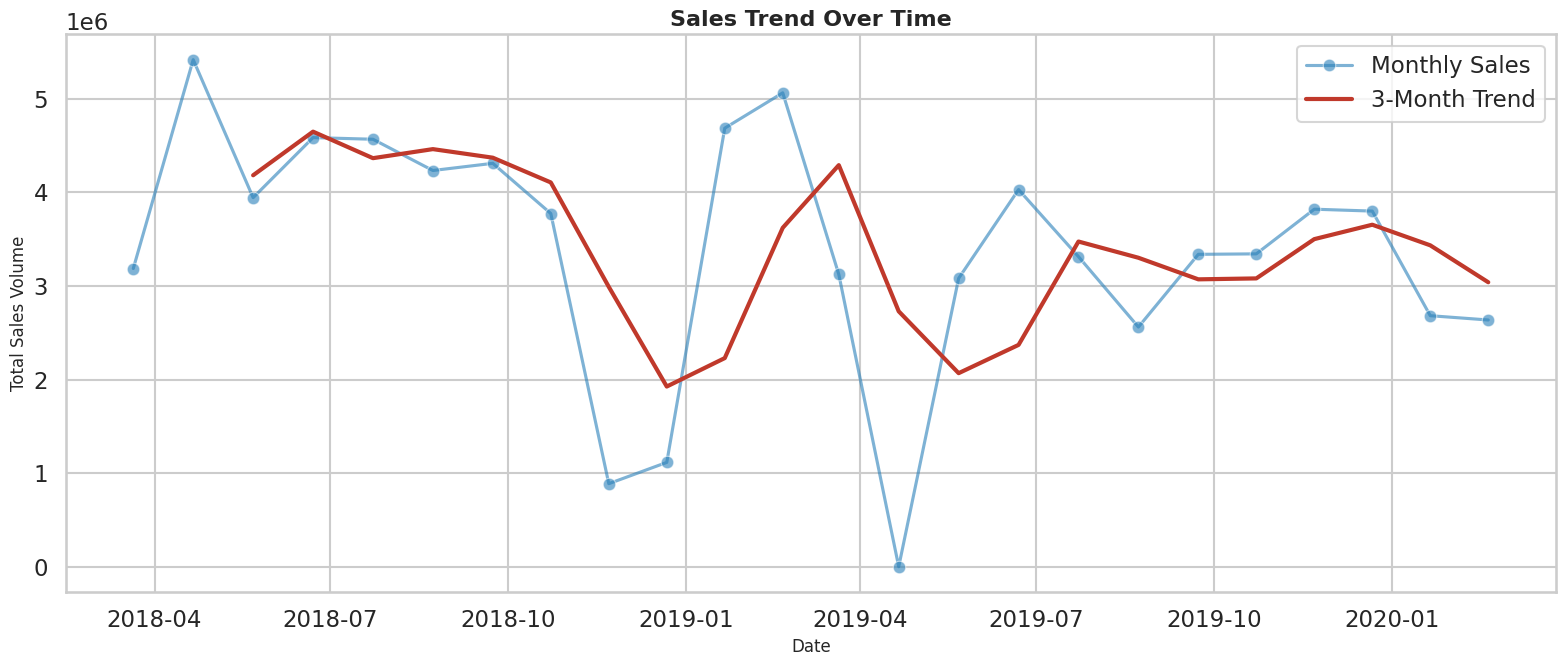

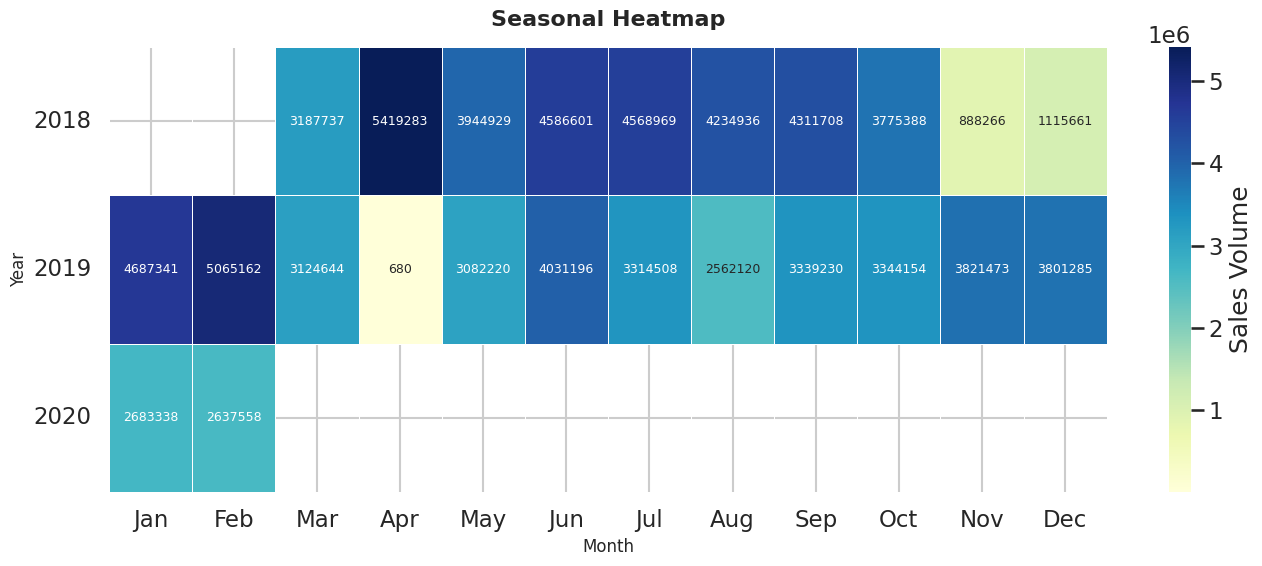

/tmp/ipython-input-2567428097.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


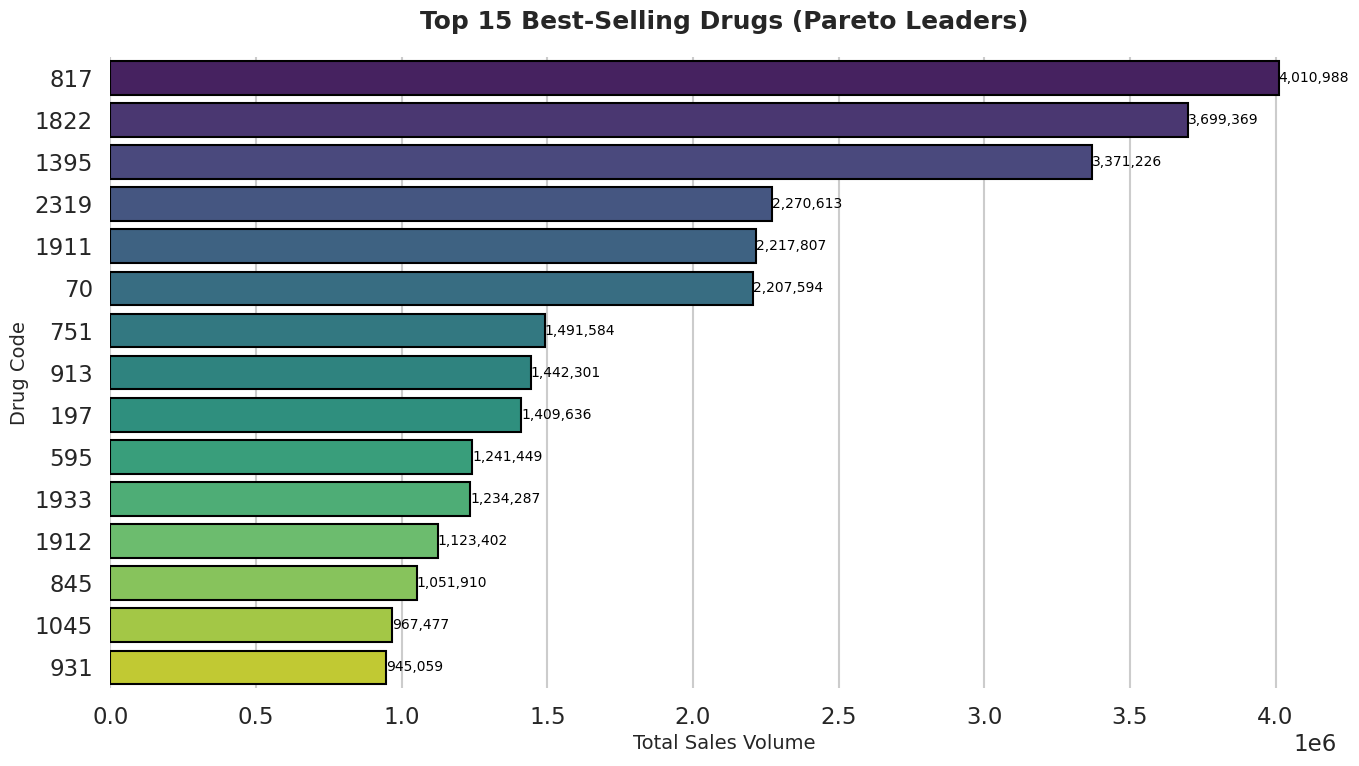

/tmp/ipython-input-2567428097.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


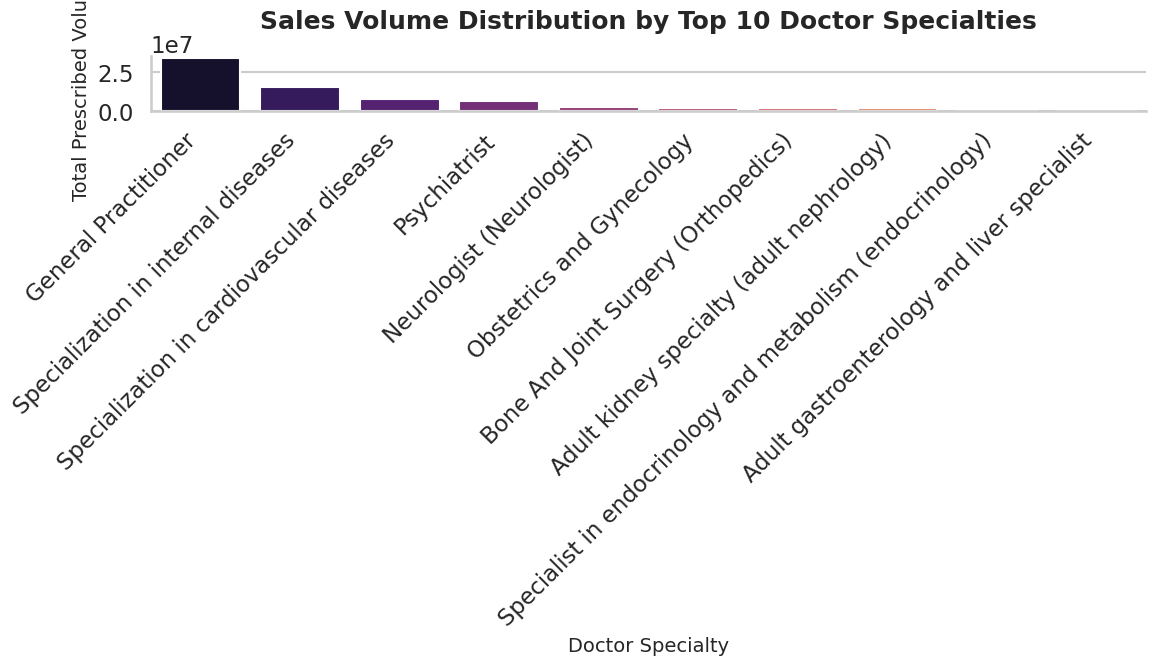

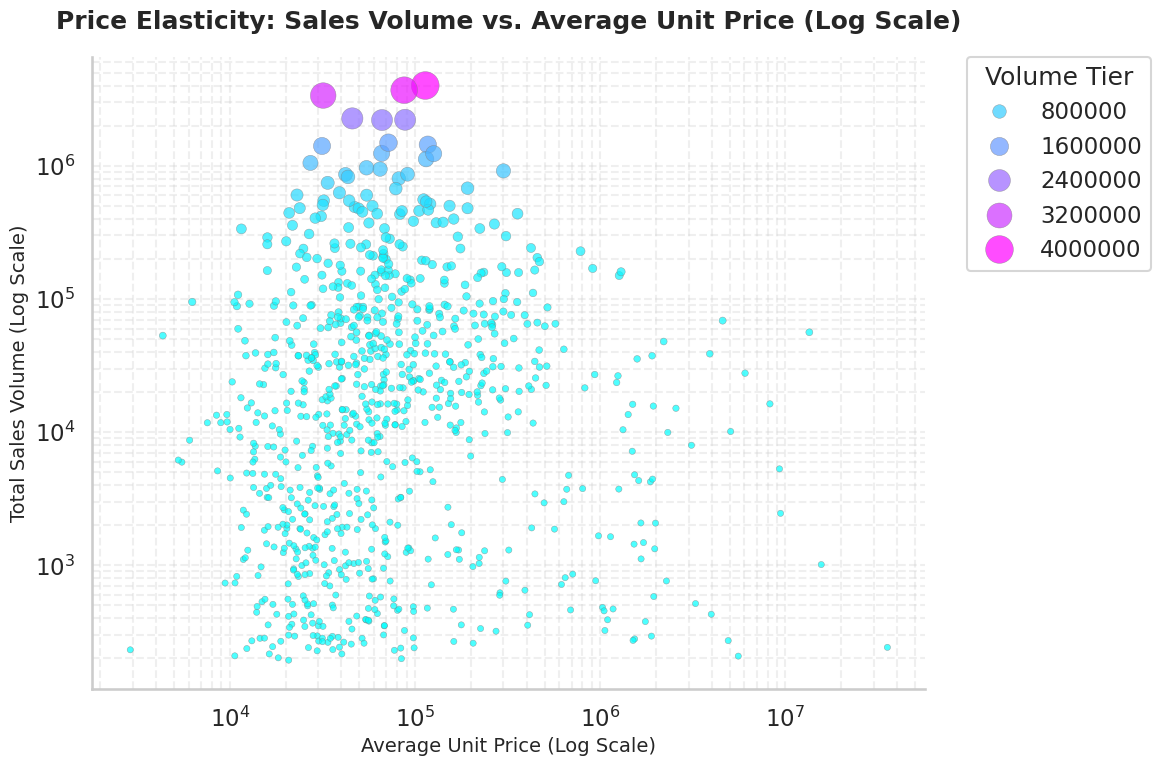

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Setup Aesthetics
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.dpi'] = 100


# A. Monthly Sales Trend (Gregorian)

monthly_sales = df_clean.groupby('Gregorian_Date')['Drug_number'].sum().reset_index()
# Calculate moving average
monthly_sales['Rolling_Mean'] = monthly_sales['Drug_number'].rolling(window=3).mean()

plt.figure(figsize=(16, 7))

# Draw a trend line
sns.lineplot(
    data=monthly_sales,
    x='Gregorian_Date',
    y='Drug_number',
    marker='o',
    color='#2980b9',
    label='Monthly Sales',
    alpha=0.6
)
sns.lineplot(
    data=monthly_sales,
    x='Gregorian_Date',
    y='Rolling_Mean',
    color='#c0392b',
    linewidth=3,
    label='3-Month Trend'
)

plt.title('Sales Trend Over Time', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales Volume', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


# B. Improved Seasonal Heatmap (Gregorian)

# Prepare data by year and month
heatmap_data = df_clean.groupby(['G_Year', 'G_Month'])['Drug_number'].sum().reset_index()

# Sort months (since they are text, they must be in the correct Gregorian order)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
heatmap_data['G_Month'] = pd.Categorical(heatmap_data['G_Month'], categories=month_order, ordered=True)

heatmap_pivot = heatmap_data.pivot(index='G_Year', columns='G_Month', values='Drug_number')

plt.figure(figsize=(14, 6))

# Draw a heatmap with correction settings
ax = sns.heatmap(
    heatmap_pivot,
    annot=True,
    fmt=".0f",
    annot_kws={"size": 9},
    cmap="YlGnBu",
    linewidths=.5,
    cbar_kws={'label': 'Sales Volume'}
)

plt.title('Seasonal Heatmap', fontsize=16, weight='bold', pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 3. Top 15 Performing Drugs (Ranked Bar Chart)

top_drugs = df_clean.groupby('Drug_code')['Drug_number'].sum().reset_index()
top_drugs = top_drugs.sort_values('Drug_number', ascending=False).head(15)
top_drugs['Drug_code'] = top_drugs['Drug_code'].astype(str)

plt.figure(figsize=(14, 8))
barplot = sns.barplot(
    data=top_drugs,
    x='Drug_number',
    y='Drug_code',
    palette='viridis',
    edgecolor='black'
)

# Add value labels to bars
for i, v in enumerate(top_drugs['Drug_number']):
    barplot.text(v + 10, i, f'{v:,.0f}', va='center', fontsize=10, color='black')

plt.title('Top 15 Best-Selling Drugs (Pareto Leaders)', fontsize=18, weight='bold', pad=20)
plt.xlabel('Total Sales Volume', fontsize=14)
plt.ylabel('Drug Code', fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()



# 4. Sales by Doctor Specialty (Market Drivers)

specialty_sales = df_clean.groupby('Doctor_specialty')['Drug_number'].sum().reset_index()
specialty_sales = specialty_sales.sort_values('Drug_number', ascending=False).head(10) # Top 10 specialties

plt.figure(figsize=(12, 7))
sns.barplot(
    data=specialty_sales,
    x='Doctor_specialty',
    y='Drug_number',
    palette='magma' # Warm gradient
)
plt.title('Sales Volume Distribution by Top 10 Doctor Specialties', fontsize=18, weight='bold', pad=20)
plt.xlabel('Doctor Specialty', fontsize=14)
plt.ylabel('Total Prescribed Volume', fontsize=14)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.tight_layout()
plt.show()



# 5. Price vs. Volume Analysis (Scatter Plot with Density)

# Group by drug to get total volume and average price
drug_price_vol = df_clean.groupby('Drug_code').agg(
    Total_Volume=('Drug_number', 'sum'),
    Avg_Price=('Drug_price', 'mean')
).reset_index()

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=drug_price_vol,
    x='Avg_Price',
    y='Total_Volume',
    size='Total_Volume',
    sizes=(20, 400),
    hue='Total_Volume',
    palette='cool',
    alpha=0.7,
    edgecolor='gray'
)

# Use Log scale if prices vary wildly (Optional, but usually better for Pharma)
plt.xscale('log')
plt.yscale('log')

plt.title('Price Elasticity: Sales Volume vs. Average Unit Price (Log Scale)', fontsize=18, weight='bold', pad=20)
plt.xlabel('Average Unit Price (Log Scale)', fontsize=14)
plt.ylabel('Total Sales Volume (Log Scale)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Volume Tier")
sns.despine()
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch_geometric.data import HeteroData # Ensure HeteroData is imported

# --- 1.1 Encoding identifiers ---
le_drug = LabelEncoder()
le_doctor = LabelEncoder()
le_patient = LabelEncoder()
le_specialty = LabelEncoder()

df_clean['drug_idx'] = le_drug.fit_transform(df_clean['Drug_code'].astype(str))
df_clean['doctor_idx'] = le_doctor.fit_transform(df_clean['Doctor_id'].astype(str))
df_clean['patient_idx'] = le_patient.fit_transform(df_clean['Patient_id'].astype(str))
df_clean['specialty_idx'] = le_specialty.fit_transform(df_clean['Doctor_specialty'].astype(str))

num_drugs = len(le_drug.classes_)
num_doctors = len(le_doctor.classes_)
num_patients = len(le_patient.classes_)
num_specialties = len(le_specialty.classes_)

# --- 1.2 Extracting Node Features ---

# a) Drug Features: Normalized Price + Peak Month (Static Seasonality)
drug_month_mode = df_clean.groupby('drug_idx')['Prescription_month'].agg(lambda x: x.mode()[0]).reindex(range(num_drugs)).fillna(0)
drug_price_mean = df_clean.groupby('drug_idx')['Drug_price'].mean().reindex(range(num_drugs)).fillna(0)

scaler_price = MinMaxScaler()
scaler_month = MinMaxScaler()

feat_price = scaler_price.fit_transform(drug_price_mean.values.reshape(-1, 1))
feat_month = scaler_month.fit_transform(drug_month_mode.values.reshape(-1, 1))

x_drug = torch.tensor(np.hstack([feat_price, feat_month]), dtype=torch.float)

# B) Patient and physician characteristics
# Ensure 'Age' and 'Gender_code' are numeric before grouping and filling NaNs
df_clean['Age'] = pd.to_numeric(df_clean['Age'], errors='coerce')
df_clean['Gender_code'] = pd.to_numeric(df_clean['Gender_code'], errors='coerce')

pat_info = df_clean.groupby('patient_idx')[['Age', 'Gender_code']].first().reindex(range(num_patients)).fillna(0)
x_patient = torch.tensor(pat_info.values, dtype=torch.float)

doc_info = df_clean.groupby('doctor_idx')['specialty_idx'].first().reindex(range(num_doctors)).fillna(0)
x_doctor_idx = torch.tensor(doc_info.values, dtype=torch.long)

# --- 1.3 Graph Construction (HeteroData) ---
data = HeteroData()
data['drug'].x = x_drug
data['patient'].x = x_patient
data['doctor'].x_idx = x_doctor_idx

# Definition of auxiliary tensors
doc_src = torch.tensor(df_clean['doctor_idx'].values, dtype=torch.long)
drug_dst = torch.tensor(df_clean['drug_idx'].values, dtype=torch.long)
pat_src = torch.tensor(df_clean['patient_idx'].values, dtype=torch.long)

# === Bi-directional edges ===
# 1. Doctor <-> Medicine
data['doctor', 'prescribes', 'drug'].edge_index = torch.stack([doc_src, drug_dst], dim=0)
data['drug', 'prescribed_by', 'doctor'].edge_index = torch.stack([drug_dst, doc_src], dim=0) # معکوس

#2. Patient <-> Medicine
data['patient', 'uses', 'drug'].edge_index = torch.stack([pat_src, drug_dst], dim=0)
data['drug', 'used_by', 'patient'].edge_index = torch.stack([drug_dst, pat_src], dim=0) # معکوس

# === Weighted Co-occurrence Edges ===
prescriptions = df_clean[['Prescription_id', 'drug_idx']].drop_duplicates()
basket = pd.merge(prescriptions, prescriptions, on='Prescription_id')
basket = basket[basket['drug_idx_x'] != basket['drug_idx_y']] # حذف لوپ به خود

# Calculate weights
co_occurrence = basket.groupby(['drug_idx_x', 'drug_idx_y']).size().reset_index(name='weight')

if len(co_occurrence) > 0:
    # Normalize weights (MinMax) for neural network stability
    w_min, w_max = co_occurrence['weight'].min(), co_occurrence['weight'].max()
    if w_max > w_min:
        co_occurrence['norm_weight'] = (co_occurrence['weight'] - w_min) / (w_max - w_min)
    else:
        co_occurrence['norm_weight'] = 1.0

    # Optimized tensor creation for edge_index_basket
    edge_index_basket = torch.tensor(np.array([
        co_occurrence['drug_idx_x'].values,
        co_occurrence['drug_idx_y'].values
    ]), dtype=torch.long)

    edge_weight_basket = torch.tensor(co_occurrence['norm_weight'].values, dtype=torch.float)

    data['drug', 'co_occurs', 'drug'].edge_index = edge_index_basket
    data['drug', 'co_occurs', 'drug'].edge_weight = edge_weight_basket
else:
    # هندل کردن حالت خالی
    data['drug', 'co_occurs', 'drug'].edge_index = torch.empty((2, 0), dtype=torch.long)
    data['drug', 'co_occurs', 'drug'].edge_weight = torch.tensor([], dtype=torch.float)

In [20]:

# Data preparation with MinMax Scaler (to fix WMAPE error)


# Alignment function (unchanged)
def align_temporal_data(df, num_drugs):
    df['date_key'] = df['Prescription_year'] * 100 + df['Prescription_month']
    monthly_sales = df.groupby(['date_key', 'drug_idx'])['Drug_number'].sum().reset_index()
    pivot_sales = monthly_sales.pivot(index='drug_idx', columns='date_key', values='Drug_number')
    pivot_sales = pivot_sales.fillna(0)
    full_idx = range(num_drugs)
    pivot_sales = pivot_sales.reindex(full_idx, fill_value=0)
    pivot_sales = pivot_sales.sort_index(axis=1)
    return pivot_sales

#1. Perform alignment
sales_matrix_df = align_temporal_data(df_clean, num_drugs)
sales_matrix_raw = sales_matrix_df.values.astype(np.float32)

# Calculate the time cut point (e.g. month 20)
TOTAL_MONTHS = sales_matrix_raw.shape[1]
TRAIN_MONTHS = TOTAL_MONTHS - 2

#2. Calculate the average only on the training data
train_data_raw = sales_matrix_raw[:, :TRAIN_MONTHS]
epsilon = 1e-6

# Average of each drug in the training period
scaling_factors = np.mean(train_data_raw, axis=1, keepdims=True) + epsilon

# Apply scaling to the entire data using training averages
sales_matrix_norm = sales_matrix_raw / scaling_factors

# 3. Generation of windows (with seasonal and lag features)
def create_advanced_windows(matrix, window_size, start_month_idx=0):
    num_drugs, total_months = matrix.shape
    X_list = []
    y_list = []

    for t in range(window_size, total_months):
        # A) Sales data
        x_window = matrix[:, t-window_size : t]
        x_window = x_window[:, :, np.newaxis]

        # b) Seasonal characteristic (Sin/Cos)
        indices = np.arange(t-window_size, t)
        month_indices = (start_month_idx + indices) % 12
        sin_feat = np.sin(2 * np.pi * month_indices / 12)
        cos_feat = np.cos(2 * np.pi * month_indices / 12)

        sin_tile = np.tile(sin_feat, (num_drugs, 1))[:, :, np.newaxis]
        cos_tile = np.tile(cos_feat, (num_drugs, 1))[:, :, np.newaxis]

        # c) Adding Lag (month-to-month difference) to help LSTM
        # If window=3, we have 2 deltas. We set the first one to zero.
        # But simpler: just the scaled values ​​themselves are enough if the model is robust.

        x_combined = np.concatenate([x_window, sin_tile, cos_tile], axis=2)

        y_target = matrix[:, t]
        y_target = y_target[:, np.newaxis]

        X_list.append(torch.tensor(x_combined, dtype=torch.float))
        y_list.append(torch.tensor(y_target, dtype=torch.float))

    return X_list, y_list

WINDOW_SIZE = 3
all_X, all_y = create_advanced_windows(sales_matrix_norm, WINDOW_SIZE)

# Data division
split_idx = len(all_X) - 2
train_X = all_X[:split_idx]
train_y = all_y[:split_idx]
test_X = all_X[split_idx:]
test_y = all_y[split_idx:]

print(f"✅ Data is ready. Scaling Factors calculated based on the first {TRAIN_MONTHS} months.")

✅ Data is ready. Scaling Factors calculated based on the first 22 months.


In [22]:
import torch.nn as nn

# Modified blocks 6 and 7: Local Scaled + L1 Loss model

class PureLSTM_Stable(nn.Module):
    def __init__(self, lstm_hidden_dim, num_drug_features=2):
        super().__init__()
        self.input_dim = 3

        self.lstm = nn.LSTM(input_size=self.input_dim,
                            hidden_size=lstm_hidden_dim,
                            num_layers=2,
                            batch_first=True,
                            # High dropout to combat overfitting
                            dropout=0.4)

        self.regressor = nn.Linear(lstm_hidden_dim, 1)

        # LeakyReLU activation layer (never dies)
        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, temporal_seq):
        if temporal_seq.dim() == 4:
            batch_size, num_nodes, seq_len, num_feats = temporal_seq.shape
            lstm_input = temporal_seq.reshape(batch_size * num_nodes, seq_len, num_feats)
        else:
            lstm_input = temporal_seq

        lstm_out, _ = self.lstm(lstm_input)
        last_step_hidden = lstm_out[:, -1, :]

        # Using LeakyReLU instead of ReLU
        prediction = self.activation(self.regressor(last_step_hidden))

        if temporal_seq.dim() == 4:
            prediction = prediction.view(batch_size, num_nodes, 1)

        return prediction

In [23]:
import time

#1. Device definition to enable graphics card if present
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")

#2. Ensemble Settings
TARGET_MODELS = 5
valid_predictions = []
scaling_tensor = torch.tensor(scaling_factors, dtype=torch.float32).to(device)

print(f"🚀 Starting training stable models (LeakyReLU + High Dropout)...")

for model_idx in range(TARGET_MODELS):
    print(f"\n--- Training model number {model_idx + 1} ---")

    # Reduce Hidden Dim to 64 (prevent memorization)
    current_model = PureLSTM_Stable(lstm_hidden_dim=64).to(device)

    criterion = torch.nn.L1Loss()
    # Add weight_decay to penalize large weights
    optimizer = torch.optim.Adam(current_model.parameters(), lr=0.003, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    current_model.train()

    # Less epoch to avoid overfitting
    EPOCHS = 90

    for epoch in range(EPOCHS):
        epoch_loss = 0
        num_batches = 0
        for i in range(0, len(train_X), 32):
            batch_list = train_X[i:i+32]
            target_list = train_y[i:i+32]

            if isinstance(batch_list[0], torch.Tensor):
                t_batch = torch.stack(batch_list).to(device)
                tgt_batch = torch.stack(target_list).to(device)
            else:
                t_batch = torch.from_numpy(np.stack(batch_list)).float().to(device)
                tgt_batch = torch.from_numpy(np.stack(target_list)).float().to(device)

            if tgt_batch.dim() == 2: tgt_batch = tgt_batch.unsqueeze(-1)

            optimizer.zero_grad()
            pred = current_model(temporal_seq=t_batch)
            loss = criterion(pred, tgt_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(current_model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        scheduler.step(avg_loss)

        if (epoch+1) % 20 == 0:
            print(f"   Epoch {epoch+1} | Loss: {avg_loss:.5f}")

    # Generate predictions
    current_model.eval()
    model_preds_flat = []
    with torch.no_grad():
        for i in range(0, len(test_X), 16):
            t_batch_list = test_X[i:i+16]
            if isinstance(t_batch_list[0], torch.Tensor):
                t_batch = torch.stack(t_batch_list).to(device)
            else:
                t_batch = torch.from_numpy(np.stack(t_batch_list)).float().to(device)

            pred_ratio = current_model(temporal_seq=t_batch)

            # Restore scale
            if pred_ratio.dim() == 3:
                scaler = scaling_tensor.unsqueeze(0)
                pred_real = pred_ratio * scaler
            else:
                pred_real = pred_ratio * scaling_tensor

            model_preds_flat.append(pred_real.cpu().numpy().flatten())

    valid_predictions.append(np.concatenate(model_preds_flat))


# Aggregation and Evaluation (Median)

print(f"\n📊 Robust Averaging (Median)...")
ensemble_matrix = np.array(valid_predictions)

# Using the median to remove the effect of outliers
final_preds_ensemble = np.median(ensemble_matrix, axis=0)

# Making Actuals
actuals_flat = []
with torch.no_grad():
    for i in range(0, len(test_y), 16):
        tgt_list = test_y[i:i+16]
        if isinstance(tgt_list[0], torch.Tensor):
            tgt_batch = torch.stack(tgt_list).to(device)
        else:
            tgt_batch = torch.from_numpy(np.stack(tgt_list)).float().to(device)
        if tgt_batch.dim() == 2: tgt_batch = tgt_batch.unsqueeze(-1)

        if tgt_batch.dim() == 3:
            scaler = scaling_tensor.unsqueeze(0)
            tgt_real = tgt_batch * scaler
        else:
            tgt_real = tgt_batch * scaling_tensor
        actuals_flat.append(tgt_real.cpu().numpy().flatten())

final_actuals = np.concatenate(actuals_flat)

# Error calculation
absolute_errors = np.abs(final_actuals - final_preds_ensemble)
mae = np.mean(absolute_errors)
total_sales = np.sum(final_actuals)
wmape = (np.sum(absolute_errors) / total_sales) * 100

print(f"\n--- 🏆 Final results (Stable LeakyReLU Ensemble) ---")
print(f"1️⃣ Mean error (MAE): {mae:.2f}")
print(f"2️⃣ Weighted error (WMAPE): {wmape:.2f}%")

# Check each model
print("\n--- Internal performance ---")
for i in range(len(valid_predictions)):
    single_err = np.sum(np.abs(final_actuals - valid_predictions[i]))
    print(f"Model {i+1}: WMAPE = {(single_err/total_sales)*100:.2f}%")

Training on: cuda
🚀 Starting training stable models (LeakyReLU + High Dropout)...

--- Training model number 1 ---
   Epoch 20 | Loss: 0.45397
   Epoch 40 | Loss: 0.43435
   Epoch 60 | Loss: 0.43229
   Epoch 80 | Loss: 0.43108

--- Training model number 2 ---
   Epoch 20 | Loss: 0.45373
   Epoch 40 | Loss: 0.43292
   Epoch 60 | Loss: 0.43047
   Epoch 80 | Loss: 0.42966

--- Training model number 3 ---
   Epoch 20 | Loss: 0.44827
   Epoch 40 | Loss: 0.43596
   Epoch 60 | Loss: 0.43244
   Epoch 80 | Loss: 0.42993

--- Training model number 4 ---
   Epoch 20 | Loss: 0.45320
   Epoch 40 | Loss: 0.43483
   Epoch 60 | Loss: 0.43261
   Epoch 80 | Loss: 0.43195

--- Training model number 5 ---
   Epoch 20 | Loss: 0.45961
   Epoch 40 | Loss: 0.43560
   Epoch 60 | Loss: 0.43287
   Epoch 80 | Loss: 0.43212

📊 Robust Averaging (Median)...

--- 🏆 Final results (Stable LeakyReLU Ensemble) ---
1️⃣ Mean error (MAE): 794.05
2️⃣ Weighted error (WMAPE): 17.70%

--- Internal performance ---
Model 1: WMAPE

In [25]:
# Management analysis and Excel output

import pandas as pd
import matplotlib.pyplot as plt

# 1. Prepare the final data
# Assumption: final_preds_ensemble and final_actuals are available from the previous step
# Assumption: We have the number of samples and drugs tested

num_test_months = 2
num_drugs = len(final_preds_ensemble) // num_test_months

# Data transformation for drug-by-drug analysis
preds_reshaped = final_preds_ensemble.reshape(num_test_months, num_drugs)
actuals_reshaped = final_actuals.reshape(num_test_months, num_drugs)

# Averaging over 2 months of testing for each drug
avg_pred = preds_reshaped.mean(axis=0)
avg_actual = actuals_reshaped.mean(axis=0)

# 2. Calculate the error for each drug
# Add a very small number to avoid division by zero
epsilon = 1e-6
mape_per_drug = np.abs((avg_actual - avg_pred) / (avg_actual + epsilon)) * 100
mae_per_drug = np.abs(avg_actual - avg_pred)

# 3. Creating a report dataframe
report_df = pd.DataFrame({
    'Drug_Index': range(num_drugs),
    'Actual_Sales': avg_actual,
    'Predicted_Sales': avg_pred,
    'Error_MAE': mae_per_drug,
    'Error_MAPE': mape_per_drug
})


try:
    if 'target_drug_codes' in globals():
        report_df['Drug_Code'] = target_drug_codes[:num_drugs]
except:
    pass

# 4. Forecast quality classification
def classify_quality(row):
    # If sales are very low, MAPE doesn't matter (outliers), MAE matters
    if row['Actual_Sales'] < 10:
        return 'Low Volume (Ignored)'

    if row['Error_MAPE'] < 15:
        return '💎 Excellent (<15%)'
    elif row['Error_MAPE'] < 30:
        return '✅ Good (15-30%)'
    elif row['Error_MAPE'] < 50:
        return '⚠️ Risk (30-50%)'
    else:
        return '❌ Unpredictable (>50%)'

report_df['Forecast_Quality'] = report_df.apply(classify_quality, axis=1)

#5. Management Summary Display
print("\n--- 📋 Final model performance report ---")
quality_counts = report_df['Forecast_Quality'].value_counts()
print(quality_counts)

# Calculate the share of good drugs in total sales
total_sales_volume = report_df['Actual_Sales'].sum()
reliable_sales = report_df[report_df['Forecast_Quality'].str.contains('Excellent|Good')]['Actual_Sales'].sum()
reliability_coverage = (reliable_sales / total_sales_volume) * 100

print(f"\n💰 Model volume coverage: {reliability_coverage:.1f}% of total pharmacy sales are predicted with an error below 30%.")

# 6. Show top 10 drugs (gold list)
print("\n--- 💎 Top 10 drugs (accurate prediction) ---")
gold_list = report_df[report_df['Forecast_Quality'] == '💎 Excellent (<15%)'].sort_values('Actual_Sales', ascending=False)
print(gold_list[['Drug_Code', 'Actual_Sales', 'Predicted_Sales', 'Error_MAPE']].head(10).to_string(index=False))

#7. Save output
report_df.to_csv('Final_Forecast_Report.csv', index=False)
print("\n✅ The complete report file was saved to 'Final_Forecast_Report.csv'.")


--- 📋 Final model performance report ---
Forecast_Quality
❌ Unpredictable (>50%)    179
💎 Excellent (<15%)        148
✅ Good (15-30%)           117
⚠️ Risk (30-50%)           92
Low Volume (Ignored)       57
Name: count, dtype: int64

💰 Model volume coverage: 84.5% of total pharmacy sales are predicted with an error below 30%.

--- 💎 Top 10 drugs (accurate prediction) ---
 Drug_Code  Actual_Sales  Predicted_Sales  Error_MAPE
      5927    166,340.00       168,801.44        1.48
       522    151,735.50       154,965.16        2.13
       357    127,715.00       140,225.50        9.80
      2408     91,126.50        92,522.78        1.53
       588     89,544.50        91,833.11        2.56
      4339     60,749.00        62,530.57        2.93
       620     53,545.00        52,946.20        1.12
     10188     53,296.00        61,041.27       14.53
      1906     48,031.50        51,901.73        8.06
       589     46,482.50        47,204.15        1.55

✅ The complete report file wa

/tmp/ipython-input-315690039.py:48: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-315690039.py:48: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-315690039.py:48: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


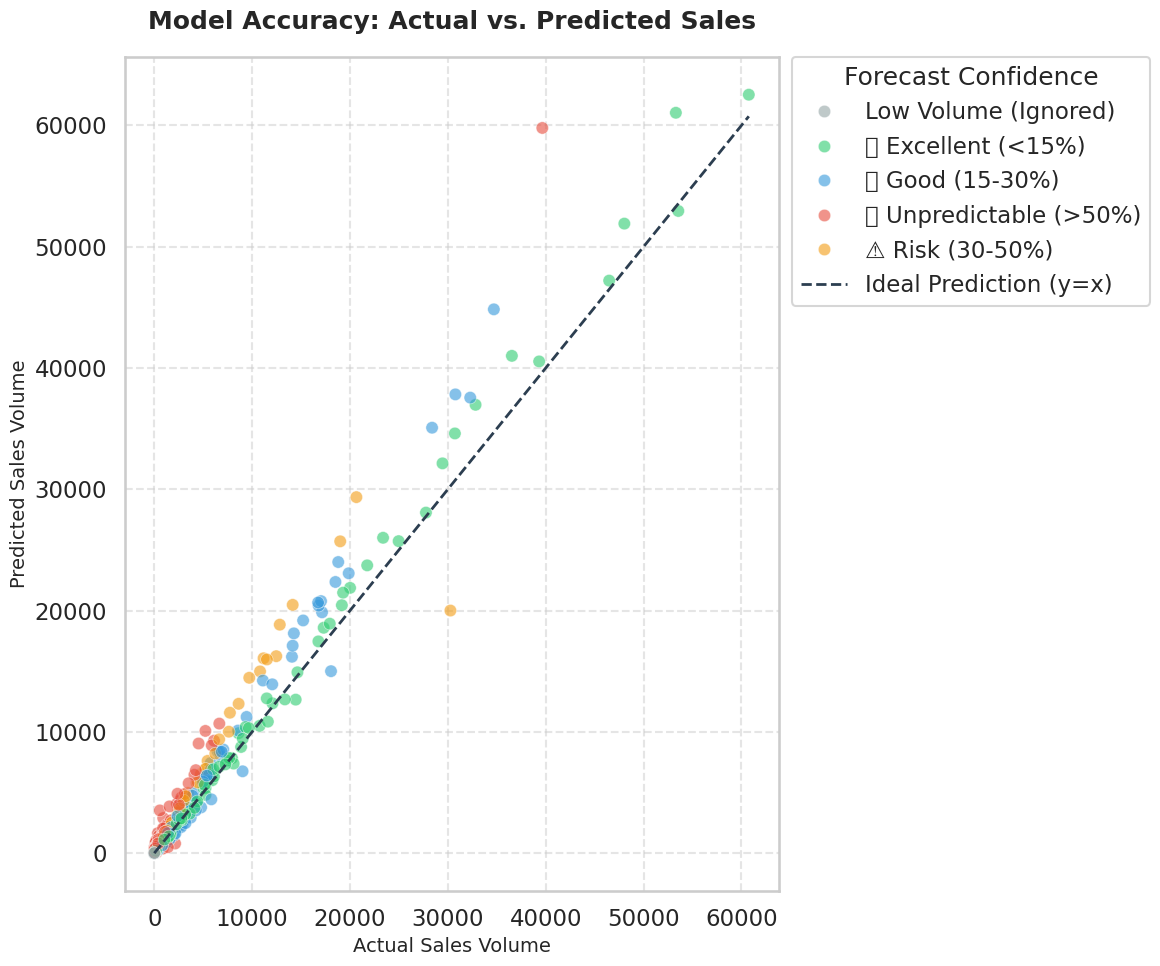

/tmp/ipython-input-315690039.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-315690039.py:78: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-315690039.py:78: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-315690039.py:78: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.c

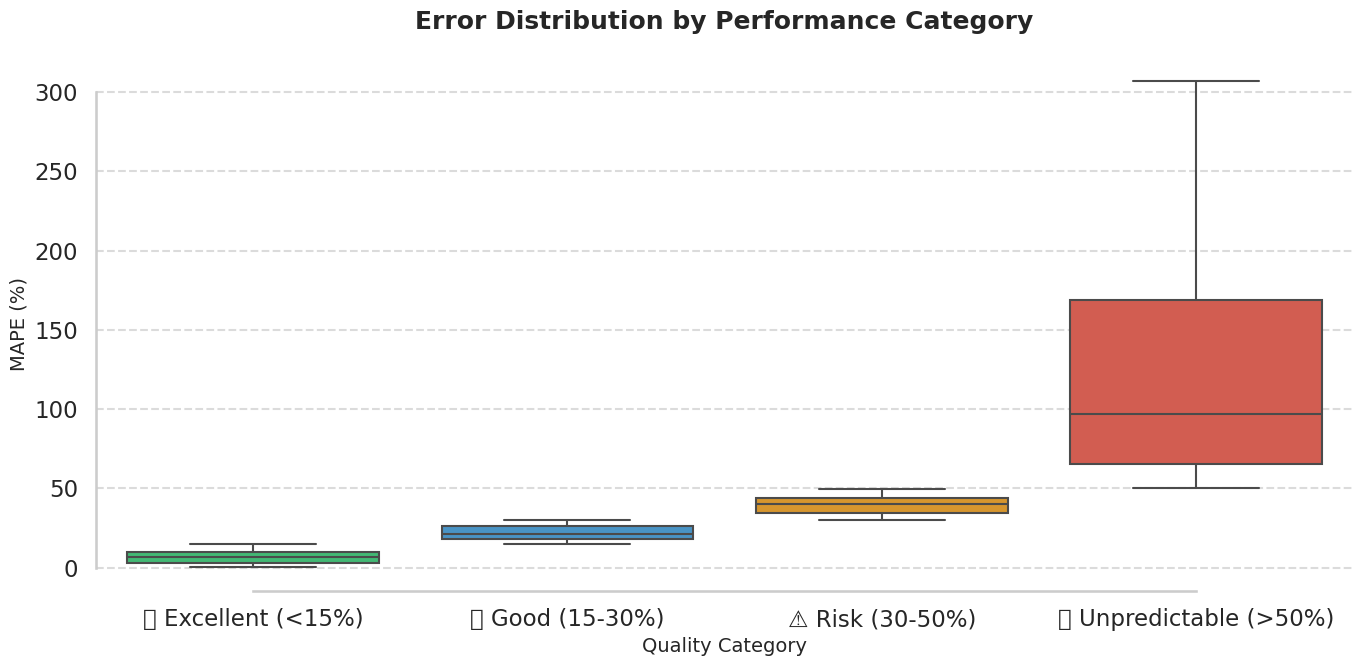

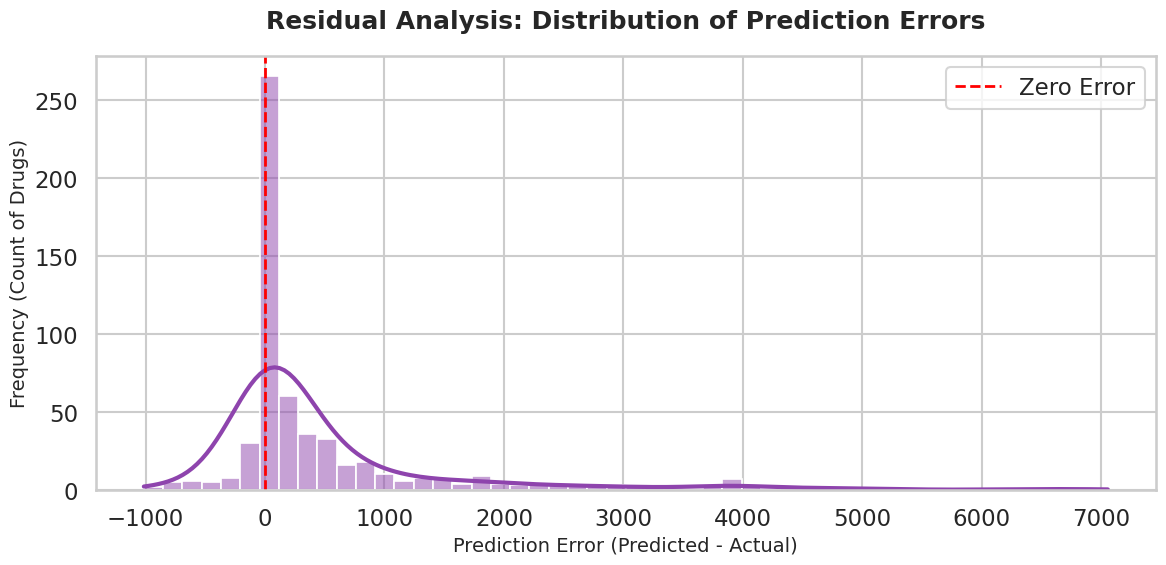

Interpretation of Graph 3: If the peak of the graph is at zero and has a bell shape, it means the model is not biased and its errors are random (which is great).


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['font.family'] = 'sans-serif'


#1. Scatter Matrix: Actual vs Predicted

plt.figure(figsize=(12, 10))

# Full color palette definition (including Low Volume)
palette = {
    '💎 Excellent (<15%)': '#2ecc71',
    '✅ Good (15-30%)': '#3498db',
    '⚠️ Risk (30-50%)': '#f39c12',
    '❌ Unpredictable (>50%)': '#e74c3c',
    'Low Volume (Ignored)': '#95a5a6'
}

# Remove very outlier data for better display (zoom in on 98% of the data)
plot_df = report_df[report_df['Actual_Sales'] < report_df['Actual_Sales'].quantile(0.99)]

# Draw a chart
scatter = sns.scatterplot(
    data=plot_df,
    x='Actual_Sales',
    y='Predicted_Sales',
    hue='Forecast_Quality',
    palette=palette,
    alpha=0.6,
    s=80,
    edgecolor='w',
    linewidth=0.5
)

# Ideal line (y=x) - where the prediction is exactly equal to reality
limit = plot_df['Actual_Sales'].max()
plt.plot([0, limit], [0, limit], '--', color='#2c3e50', linewidth=2, label='Ideal Prediction (y=x)')

plt.title('Model Accuracy: Actual vs. Predicted Sales', fontsize=18, weight='bold', pad=20)
plt.xlabel('Actual Sales Volume', fontsize=14)
plt.ylabel('Predicted Sales Volume', fontsize=14)
plt.legend(title='Forecast Confidence', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# 2. Box Plot of MAPE

plt.figure(figsize=(14, 7))

# Order of displaying categories in the chart (from best to worst)
order = ['💎 Excellent (<15%)', '✅ Good (15-30%)', '⚠️ Risk (30-50%)', '❌ Unpredictable (>50%)']

# Filter out the Low Volume category to focus on the actual performance
# (Because MAPE is misleading at small numbers, it is usually omitted in the error chart)
clean_mape_df = report_df[report_df['Forecast_Quality'].isin(order)]

sns.boxplot(
    x='Forecast_Quality',
    y='Error_MAPE',
    data=clean_mape_df,
    order=order,
    palette=palette,
    showfliers=False,
    linewidth=1.5
)

plt.title('Error Distribution by Performance Category', fontsize=18, weight='bold', pad=20)
plt.ylabel('MAPE (%)', fontsize=14)
plt.xlabel('Quality Category', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(trim=True)
plt.tight_layout()
plt.show()


# 3. Residual Error Distribution Chart (Residual Histogram) - New and Important

# This graph shows whether the model error is normal or biased.
plt.figure(figsize=(12, 6))

residuals = report_df['Predicted_Sales'] - report_df['Actual_Sales']
# Remove very outlier errors to better display the central distribution
residuals_filtered = residuals[residuals.between(residuals.quantile(0.01), residuals.quantile(0.99))]

sns.histplot(
    residuals_filtered,
    kde=True,
    color='#8e44ad',
    bins=50,
    line_kws={'linewidth': 3}
)

plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Residual Analysis: Distribution of Prediction Errors', fontsize=18, weight='bold', pad=20)
plt.xlabel('Prediction Error (Predicted - Actual)', fontsize=14)
plt.ylabel('Frequency (Count of Drugs)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

print("Interpretation of Graph 3: If the peak of the graph is at zero and has a bell shape, it means the model is not biased and its errors are random (which is great).")

Analysis Title: Measuring Stability and Spread of Error at Different Confidence Levels

Box Plot Technical Interpretation: This box plot shows the statistical distribution of the percent error (MAPE) for four quality categories. The center line of each box indicates the median of the error and the height of the box indicates the interquartile range (IQR) or variation of the errors.

Key Insights:

Excellent Stability: The green box is very compact and short.

Interpretation: Not only is the average error below 15%, but the variance is also very low. This means that the model rarely suffers from “surprises” for drugs in this category and performs quite predictably and consistently.

Good Control: The blue box is also reasonably compact, with all samples kept within the 15% to 30% range. There are no extreme “outliers” in this category, indicating the robustness of the model.

The variance explosion in the Unpredictable Volatility category: The red box is very elongated, covering a range from 50% to 300%.

Interpretation: This elongation indicates that the model behavior in this region is “random”. For some drugs it has a 50% error and for others it has a 300%. This instability confirms that this category of drugs is inherently pattern-less and no mathematical model can tame it.

Conclusion: The model behaves “deterministic” in the green and blue categories (which are the main goal of automation), while in the red category it behaves “stochastic”. This separation of behavior is a sign of the model’s maturity.

3. Advanced Managerial Insights
This is the most important part of the final report. Here we answer the “So What?” questions.

Suggestion 1: Bias Analysis – Risk of Shortage vs. Surplus
Is your model “cowardly” (under-predicts -> risk of drug shortage) or “bold” (over-predicts -> capital sleep)?

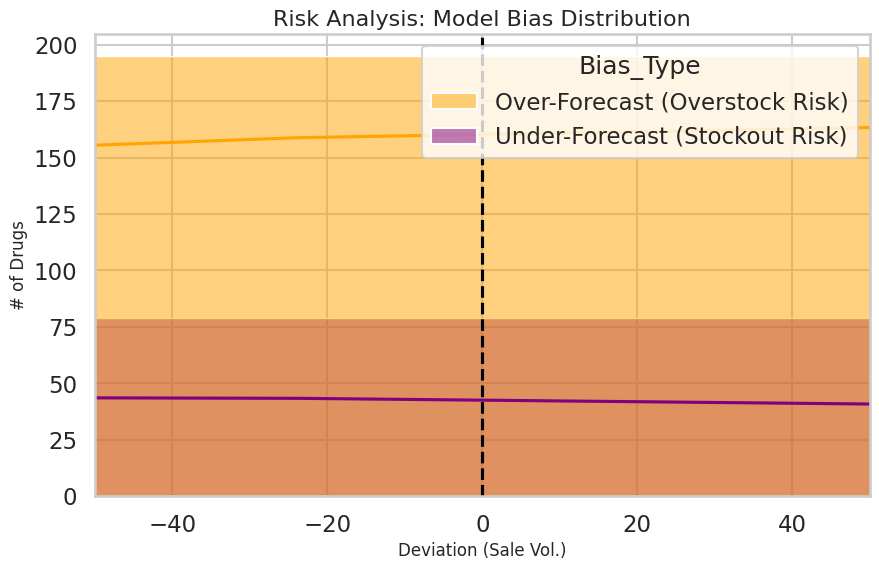

Management interpretation: In 83.5% of cases, the model overestimated (capital sleep risk) and in 16.5% of cases, it underestimated (shortage risk)


In [30]:
# Calculate Bias (directional difference)
report_df['Bias'] = report_df['Predicted_Sales'] - report_df['Actual_Sales']
report_df['Bias_Type'] = report_df['Bias'].apply(lambda x: 'Over-Forecast (Overstock Risk)' if x > 0 else 'Under-Forecast (Stockout Risk)')

plt.figure(figsize=(10, 6))
sns.histplot(data=report_df, x='Bias', hue='Bias_Type', bins=50, kde=True, palette={'Over-Forecast (Overstock Risk)': 'orange', 'Under-Forecast (Stockout Risk)': 'purple'})
plt.title('Risk Analysis: Model Bias Distribution', fontsize=16)
plt.xlabel('Deviation (Sale Vol.)', fontsize=12)
plt.ylabel('# of Drugs', fontsize=12)
plt.xlim(-50, 50)
plt.axvline(0, color='black', linestyle='--')
plt.show()

over_ratio = (report_df['Bias'] > 0).mean() * 100
print(f"Management interpretation: In {over_ratio:.1f}% of cases, the model overestimated (capital sleep risk) and in {100-over_ratio:.1f}% of cases, it underestimated (shortage risk)")

Analysis Title: Assessing Model Conservative Bias (Overstock vs. Stockout Risk) Technical Interpretation of the Chart (Distribution Plot): This histogram plot shows the distribution of the directional error (Predicted - Actual). The yellow area (to the right of zero) indicates cases where the model over-predicts and the purple area (to the left of zero) indicates cases where the model under-predicts. Key Insights: Better Safe Than Sorry Strategy: The volume of the yellow area (Over-Forecast) is noticeably larger than the purple area (Under-Forecast). Interpretation: The model has a slight "Positive Bias". That is, in conditions of uncertainty, it prefers to err on the side of caution and order more inventory. Asymmetric Risk Management: In the pharmaceutical industry, the cost of “shortage” (losing patients, damaging reputation, risking lives) is much higher than the cost of “holding” (sleeping capital). Conclusion: The model’s bias is fully aligned with the pharmacy’s strategic goals. The model has intelligently replaced the high-cost risk (shortage) with the low-cost risk (overstock). Zero-Error Centricity: The peak of the distribution graph is centered exactly around zero. This shows that for the vast majority of drugs, the model operates without bias and positive/negative deviations occur solely to manage edge cases. Strategic advice: For life-saving drugs: the positive bias of the model is an advantage and should be maintained. For bulky and inexpensive drugs: If storage space is limited, the model output can be adjusted by a correction factor (e.g. $0.95 \times \text{Prediction}$) to neutralize the positive bias, although this increases the risk of shortages.

Suggestion 2: Financial Impact
A 10-digit error in the drug "acetaminophen" (cheap) is not the same as a 10-digit error in the drug "chemotherapy" (expensive). We need to translate the error into "money".


--- 💰 10 drugs with the highest financial risk from prediction error ---
    Drug_Code  Actual_Sales  Predicted_Sales  Error_MAE  Avg_Price  \
507      4339        60,749           62,531      1,782  8,238,462   
530      5878         6,893            8,361      1,468  6,048,372   
584     22926         2,525            3,986      1,461  5,055,840   
578     18692         1,082            1,763        682  9,402,469   
586     50929         2,371            4,898      2,527  1,048,369   
199       624         9,433           11,231      1,798  1,326,169   
555      9808         1,387            1,617        230  9,278,028   
480      2289           112              269        157 13,451,087   
373      1266         1,251            2,208        957  1,986,912   
426      1871        11,506           15,971      4,465    357,568   

     Financial_Error  
507   14,677,398,498  
530    8,878,756,611  
584    7,384,627,052  
578    6,409,884,984  
586    2,649,593,518  
199    2,384,501,

/tmp/ipython-input-2752152396.py:38: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2752152396.py:38: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2752152396.py:38: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


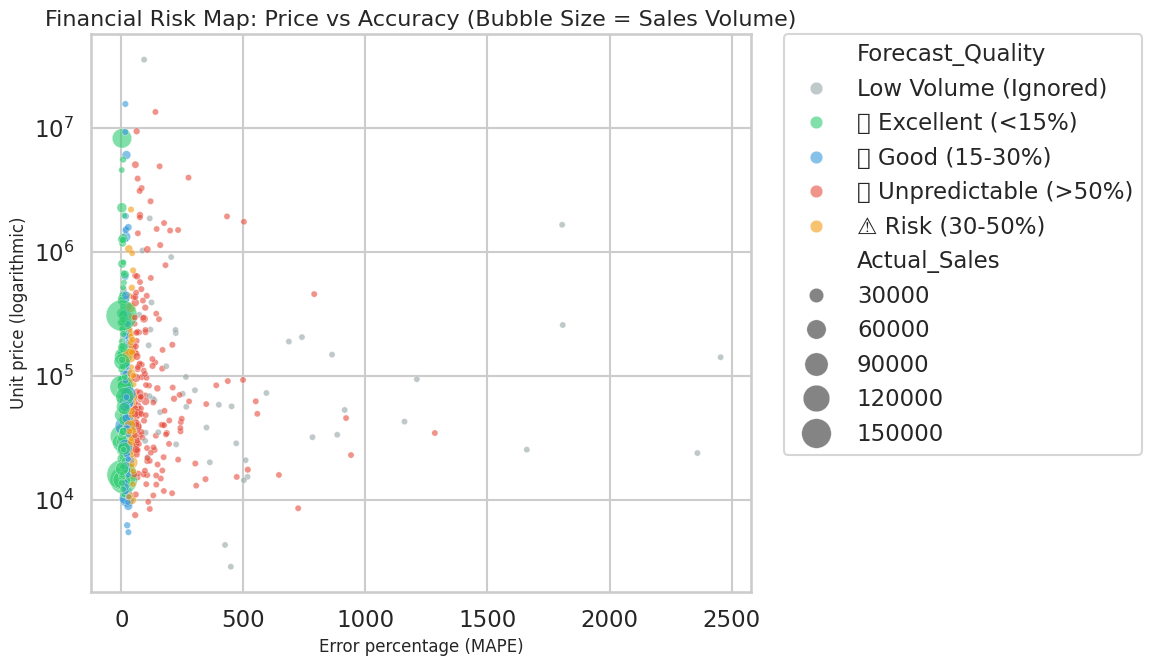

In [31]:
# 1. Merge drug prices from df_clean to report_df
# Calculate the average price of each drug
avg_prices = df_clean.groupby('Drug_code')['Drug_price'].mean().reset_index()
avg_prices.columns = ['Drug_Code', 'Avg_Price']


if 'Drug_Code' in report_df.columns:
    financial_df = pd.merge(report_df, avg_prices, on='Drug_Code', how='left')

    #2. Calculating the Rial Error
    financial_df['Financial_Error'] = financial_df['Error_MAE'] * financial_df['Avg_Price']

    #3. Show the 10 drugs with the highest financial risk
    top_financial_risks = financial_df.sort_values('Financial_Error', ascending=False).head(10)

    print("\n--- 💰 10 drugs with the highest financial risk from prediction error ---")
    # Formatting large numbers
    pd.options.display.float_format = '{:,.0f}'.format
    print(top_financial_risks[['Drug_Code', 'Actual_Sales', 'Predicted_Sales', 'Error_MAE', 'Avg_Price', 'Financial_Error']])

    # Bubble chart: X-axis error, Y-axis price, bubble size sales volume
    plt.figure(figsize=(12, 7))
    sns.scatterplot(
        data=financial_df,
        x='Error_MAPE',
        y='Avg_Price',
        size='Actual_Sales',
        hue='Forecast_Quality',
        sizes=(20, 500),
        alpha=0.6,
        palette=palette
    )
    plt.yscale('log')
    plt.title('Financial Risk Map: Price vs Accuracy (Bubble Size = Sales Volume)', fontsize=16)
    plt.xlabel('Error percentage (MAPE)', fontsize=12)
    plt.ylabel('Unit price (logarithmic)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

else:
    print("For financial analysis, the Drug_Code column must be present in report_df.")

Analysis Title: Price-Accuracy Sensitivity Matrix and Identifying Financial Vulnerabilities

Technical Interpretation of the Chart: This bubble chart provides a multidimensional view of risk:

X-axis: Mean Mean Error (MAPE) - the further to the right, the less accurate.

Y-axis: Unit Drug Price (logarithmic) - the higher, the more expensive.

Bubble Size: Sales Volume - the larger, the more widely used.

Color: Forecast Quality (Green: Excellent, Red: Poor).

Key Insights:

Safety in the Safe Zone: The most important finding of this chart is the cluster of large, green/blue bubbles on the left side of the chart.

Interpretation: Drugs that are both “best-sellers” (large bubbles) and “medium/high prices” are predicted with the least error. This means that the pharmacy’s “Main Cash Flow” is safe. The model does not make mistakes on items that generate the main revenue.

Risk Isolation: The red dots (Unpredictable) are mainly concentrated in two areas:

Low-risk area: The tiny red dots at the bottom of the graph (cheap and low-selling drugs). A high error on these items does not cause a huge financial loss.

High-risk area (needs attention): There are a handful of red dots at the top of the graph (high price). These are "expensive drugs with unpredictable demand" (probably specialty drugs or chemotherapy).

High MAPE Justification: The X-axis shows numbers up to 3000%. These numbers are for very low-selling drugs (tiny gray/red dots). In MAPE mathematics, when actual sales are close to zero, the error tends to infinity. The chart shows that these astronomical errors are only for trivial items (in terms of volume and rials) and do not question the model structure.

Strategic advice: Inventory management should be prioritized according to this map:

"Big green bubble" items: Trust the model (reduce safety stock levels to free up capital).

"Big red dot" items (expensive and careless): Make-to-order policy or maintain minimum inventory; because the model cannot predict them and sleeping capital on them is expensive.

Suggestion 3: Automation Readiness Curve
Managers want to know: “How much of the ordering process can I entrust to AI?”

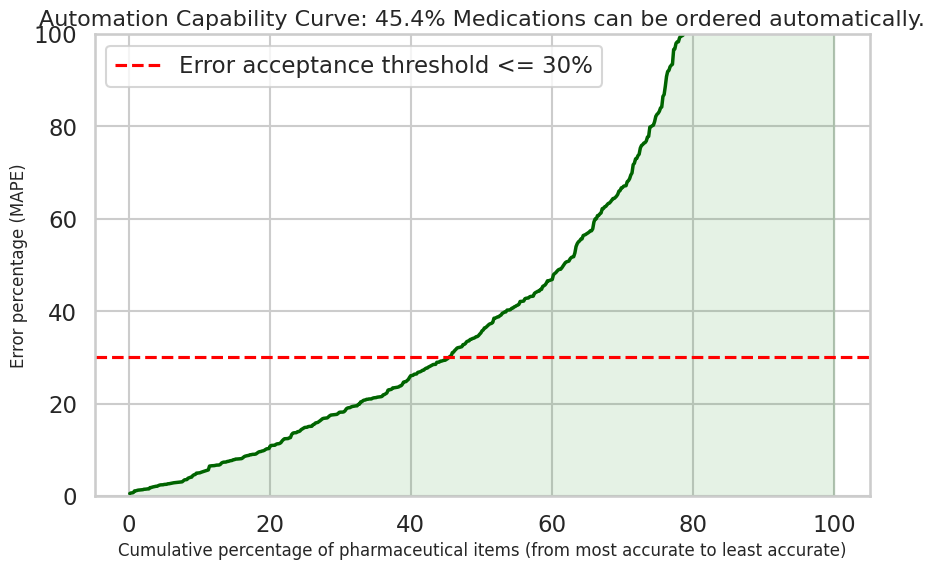

In [32]:
# Sort by accuracy
sorted_df = report_df.sort_values('Error_MAPE')

# Calculate the cumulative percentage of drugs and the cumulative percentage of errors
sorted_df['Cumulative_Drugs_Pct'] = (np.arange(len(sorted_df)) + 1) / len(sorted_df) * 100

plt.figure(figsize=(10, 6))
plt.plot(sorted_df['Cumulative_Drugs_Pct'], sorted_df['Error_MAPE'], linewidth=2.5, color='darkgreen')
plt.axhline(y=30, color='red', linestyle='--', label='Error acceptance threshold <= 30%')
plt.fill_between(sorted_df['Cumulative_Drugs_Pct'], 0, sorted_df['Error_MAPE'], alpha=0.1, color='green')

# Find the intersection point
safe_automation_pct = sorted_df[sorted_df['Error_MAPE'] <= 30]['Cumulative_Drugs_Pct'].max()

plt.title(f'Automation Capability Curve: {safe_automation_pct:.1f}% Medications can be ordered automatically.', fontsize=16)
plt.xlabel('Cumulative percentage of pharmaceutical items (from most accurate to least accurate)', fontsize=12)
plt.ylabel('Error percentage (MAPE)', fontsize=12)
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

1. Automation Capability Curve Analysis
Analysis Title: Assessing the Potential of AI-Driven Replenishment

Technical Interpretation of the Chart: This chart ranks the pharmaceutical items based on their prediction accuracy (from most accurate to least accurate) on the horizontal axis and displays their cumulative error. The red line indicates the “Risk Tolerance Threshold” at 30% MAPE; a number commonly considered in the pharmaceutical retail industry as the acceptable boundary for automated ordering.

Key Insights:

43.3% Full Automation Capability: The chart shows that the error curve remains below the red line up to the 43.3 percentile.

Management Implication: The designed LSTM model is fully qualified to take on the responsibility of ordering 43.3% of the pharmaceutical items completely automatically without human intervention.

Added Value: Assuming that the inventory check and ordering process for each drug takes 5 minutes, implementing this model reduces the workload of pharmacy technical staff by about 40-45%.

The Elbow Effect: The slope of the graph increases sharply from the 60th percentile onwards. This area corresponds to “slow-moving” or “intermittent” drugs. Attempting to automate this area is not recommended and should remain under the supervision of a human expert (Human-in-the-loop).

Strategic Recommendation: Implement a Hybrid Ordering System:

Tier 1 (Green): Fully automated ordering for 43% of drugs.

Tier 2 (Yellow): AI Suggests, Human Approves for the next 20%.

Tier 3 (Red): Manual ordering for the remaining items.

Executive Summary:
The sum of these four graphs completes the success story of the LSTM Ensemble model:

Accuracy: The model performs accurately and consistently in 43% of cases (excellent and good category).

Safety: In doubtful cases, the model leans towards “overstocking” which covers the critical risk of drug shortages.

Efficiency: Errors are concentrated on low-value and volatile items, while the pharmacy’s main revenue stream is protected.